# Conditional GAN

Just like conditional VAE, in GAN we can also condition on the label to generate class specific images. This is done through concatencating the embedded labels with the extracted image features. Below, we implement conditional GAN and test it on MNIST images. 

## Generator/discriminator implementation

For the generator and discriminator, we used a simple convolutional neural network. The architecture is shown below.

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from CGAN import *

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

cifar_transform = transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_dataset = torchvision.datasets.CIFAR10(root="./data", download=True,
                           transform=cifar_transform)

cifar_dataloader = torch.utils.data.DataLoader(cifar_dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, embed_dim, n_classes=10):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, embed_dim)
        self.label_scaling = nn.Linear(embed_dim, 32**2)
        self.net = nn.Sequential(nn.Conv2d(in_channels+1, 128, 3, 2, 1),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(128, 128, 3, 2, 1),
                                 nn.LeakyReLU(0.2),
                                 nn.Flatten(),
                                 nn.Dropout(0.4),
                                 nn.Linear(8*32**2, 1))

    def forward(self, x, label):
        label = self.label_embedding(label)
        label = self.label_scaling(label)
        label = label.view(-1, 1, 32, 32)
        x = torch.cat([x, label], dim=1)
        x = self.net(x)
        return x

class Generator(nn.Module):
    def __init__(self, in_channels, embed_dim, noise_dim, n_classes=10):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, embed_dim)
        self.label_scaling = nn.Linear(embed_dim, 8*8)
        self.noise_scaling = nn.Linear(noise_dim, 8*8*128)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=129, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=in_channels, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x, label):
        label = self.label_embedding(label)
        label = self.label_scaling(label)
        x = self.noise_scaling(x)
        x = x.view(-1, 128, 8, 8)
        label = label.view(-1, 1, 8, 8)
        x = torch.cat([x, label], dim=1)
        return self.net(x)

class ConditionalGAN(nn.Module):
    def __init__(self, in_channels, embed_dim, noise_dim, n_classes=10):
        super(CGAN, self).__init__()
        self.generator = Generator(in_channels, embed_dim, noise_dim, n_classes)
        self.discriminator = Discriminator(in_channels, embed_dim, n_classes)
        self.noise_dim = noise_dim
        self.n_classes = n_classes

    def sample(self, n_samples, label, device="cpu"):
        self.generator.eval()
        self.discriminator.eval()
        fixed_noise = torch.randn(n_samples, self.noise_dim).to(device)
        samples = self.generator(fixed_noise, label)
        samples = ((samples + 1) * 0.5)
        samples = samples.clamp(0, 1)
        samples = samples.cpu().detach().numpy()
        samples = np.transpose(samples, (0, 2, 3, 1))
        return samples

## Test on MNIST

We train the conditional GAN for around $10$ epochs using Adam optimizer with learning rate of $0.001$ and beta $(0.5, 0.999)$. The generated sample is shown below. We see that the model is able to generate class specific images. 

In [ ]:
cgan = ConditionalGAN(1, 50, 100).to(DEVICE)
optimizerD = optim.Adam(cgan.discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerG = optim.Adam(cgan.generator.parameters(), lr=0.001, betas=(0.5, 0.999))
train(cgan, train_loader, optimizerD, optimizerG, 10)

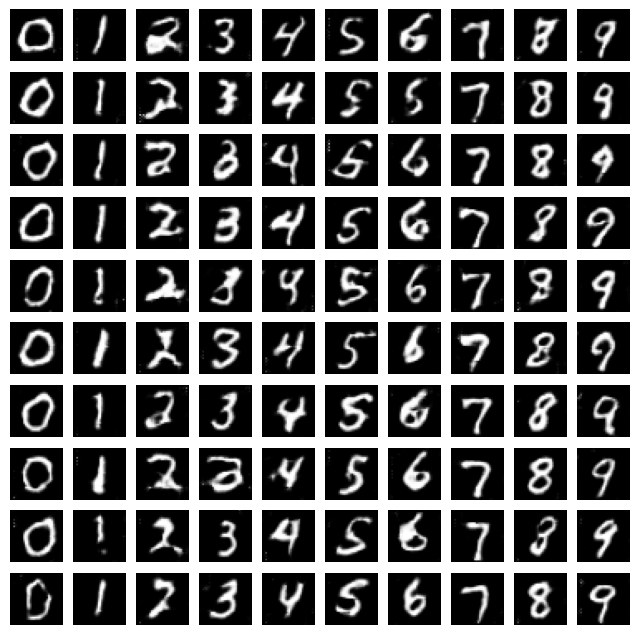

In [7]:
plot_samples()